# Current stability analysis

This notebook analyses the measurments taken using a [YHDC current transformer](https://www.amazon.co.uk/dp/B01EFTMCIE/ref=pe_3187911_189395841_TE_3p_dp_1) to measure stability of the  current being delivered to the heating jacket wrapped around my cold fusion reactor.

The data can be found in [202002-current-tests](../../data/202002-current-tests/).

See my [control experiment blog post](https://gitlab.com/mklilley/lenr/issues/2#note_284252505) for more context.

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px # note, to make the plots in this notebook interactive just remove renderer="png"
from scipy import signal

## Source

The time column is unix time in seconds. We must parse it in a special way to turn it into a nice date-time type.

In [18]:
df = pd.read_csv("../../data/202002-current-tests/20200204-current-test.csv",parse_dates=["time(s)"], 
                 date_parser=lambda row: pd.to_datetime(row, unit='s'))

In [19]:
df.head()

time(s)  current(A)
0 2020-02-04 12:22:04       1.465
1 2020-02-04 12:22:14       1.416
2 2020-02-04 12:22:24       1.416
3 2020-02-04 12:22:34       1.416
4 2020-02-04 12:22:44       1.416

## Explore

The data consists of readings from a [current clamp sensor](https://www.amazon.co.uk/dp/B01EFTMCIE/ref=pe_3187911_189395841_TE_3p_dp_1) that's clamped around the wire feeding the [heating jacket with AC](https://mattlilley.com/uxkyUqMjDfKa5SUtB67c/IMG-20200204-test-heater-current.jpg).

The data is collected every 10s. It creates a signal that looks a bit noisy.



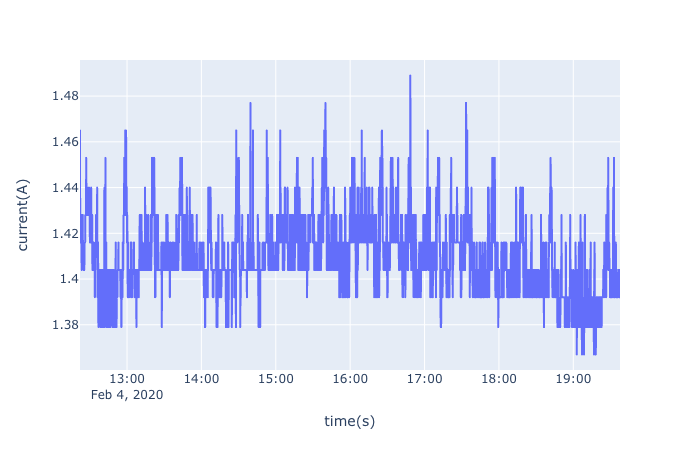

In [20]:
fig = px.line(df,x="time(s)",y="current(A)")
fig.show(renderer="png")

Most of the data is contained within 4 Arduino sensor bins

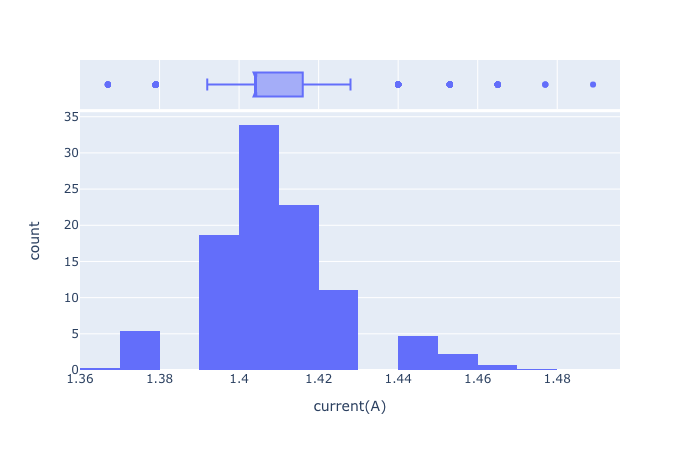

In [21]:
fig = px.histogram(df, x="current(A)",histnorm='percent',marginal="box")
fig.show(renderer="png")

Taking a moving average of 10 (i.e. 100s) creates a signal that clearly shows some periodicity.

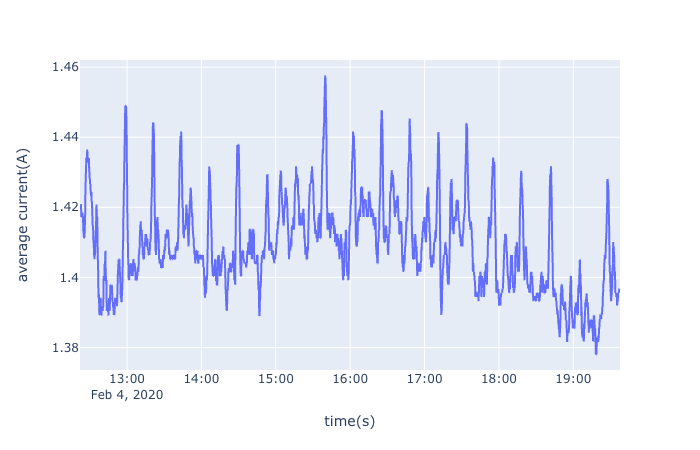

In [22]:
df["average current(A)"] = df.rolling(10,center=True).mean()
fig = px.line(df,x="time(s)", y="average current(A)")
fig.show(renderer="png")

## Frequency analysis

By analysing the signal in frequency space we can pick out any dominant frequency components.

In [23]:
f, Pxx_den = signal.periodogram(df["current(A)"].dropna(), fs=0.1) # fs=0.1 means data points every 1/0.1=10s
spectrum = pd.DataFrame(data={"frequency (Hz)":f, "power spectral density":np.sqrt(Pxx_den)})

The most striking frequency components are
- 38$\mu$Hz - i.e. perdiod of 7.3 hours - **long time behaviour seen in temperature oscillations**
- 727$\mu$Hz (and integer multiples) - i.e. period of 23 minutes

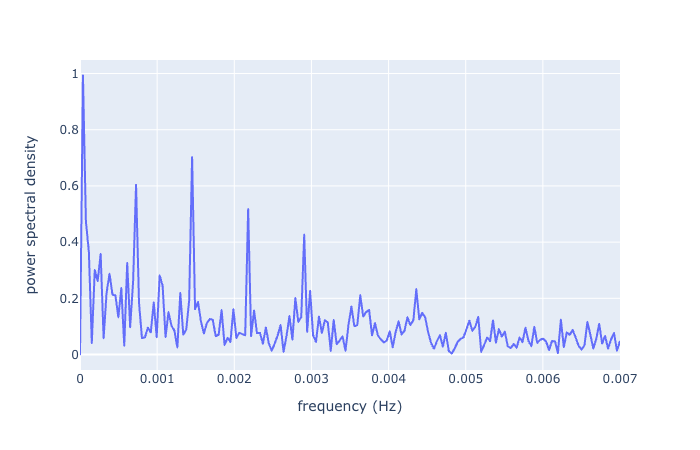

In [24]:
fig = px.line(spectrum,x="frequency (Hz)", y="power spectral density",range_x=[0,0.007])
fig.show(renderer="png")

Create a function to make it easy to create the spectrum for another dataset

In [5]:
def plot_spec(filename):
    data = pd.read_csv(filename,parse_dates=["time(s)"], 
                 date_parser=lambda row: pd.to_datetime(row, unit='s'))
    freq, PSD2 = signal.periodogram(data["current(A)"], fs=0.1)
    spec = pd.DataFrame(data={"frequency (Hz)":freq, "power spectral density":np.sqrt(PSD2)})
    return px.line(spec,x="frequency (Hz)", y="power spectral density",range_x=[0,0.007])

We've just looked at 04/02/2020, now let's look at 05/02/2020 - same setup.
The dominant frequency components are very close to what we have seen before.
- 40$\mu$Hz - i.e. perdiod of 7 hours - **long time behaviour seen in temperature oscillations**
- 696$\mu$Hz (and integer multiples) - i.e. period of 24 minutes

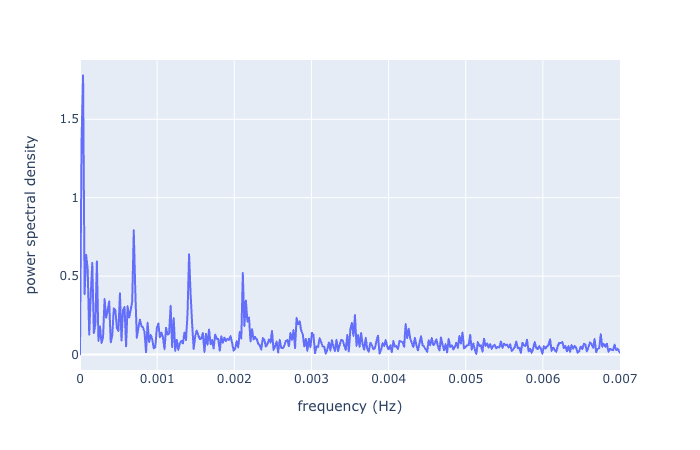

In [25]:
fig = plot_spec("../../data/202002-current-tests/20200205-current-test.csv")
fig.show(renderer="png")

The next dataset was collected when the current clamp sensor wasn't clamped around a source of current. This should be the measurement of zero current.

This time we do not see the lowest frequency component, We still see 715$\mu$Hz and multiples of it.

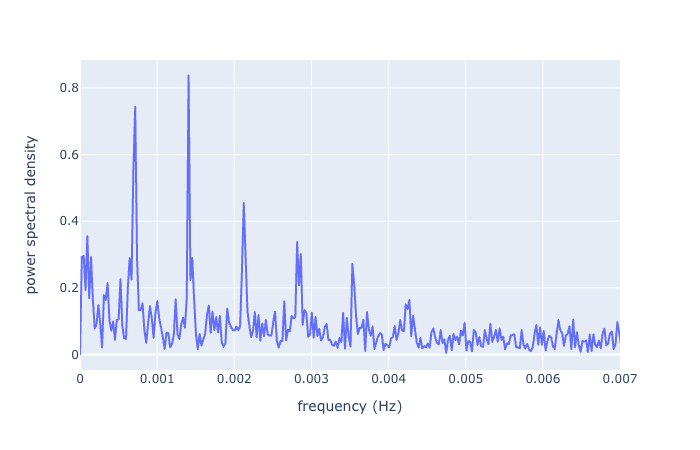

In [26]:
fig = plot_spec("../../data/202002-current-tests/20200205-current-test-no-source.csv")
fig.show(renderer="png")

I changed the 10k$\Omega$ resistors to 100k$\Omega$ in the hopes that it might help with what appears to be electrical noise. The data still shows a the same frequencies.

Curiously, the low frequency component has returned in this signal, albeit slighy higher than before.

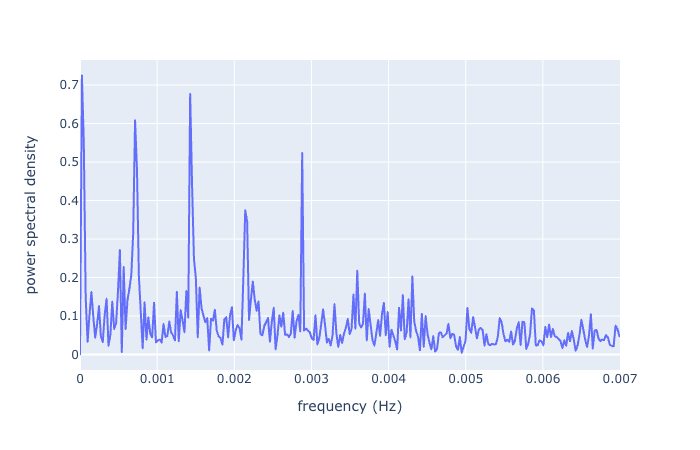

In [27]:
fig = plot_spec("../../data/202002-current-tests/20200206-current-test-no-source-100k.csv")
fig.show(renderer="png")

I then changed the time window over which I sample the AC. In particular, I changed it from 1000ms to the prime number 997ms. I did this just in case the periodicity was somehow coming from unexpected interaction between the period of the signal and my that of my sampling window.

The same frequency components persist.

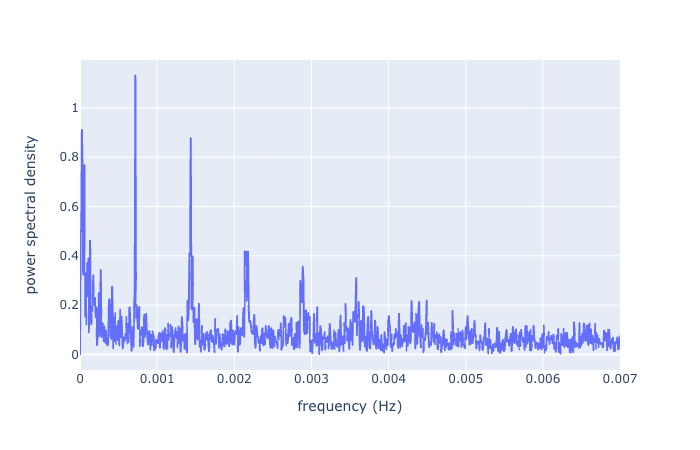

In [28]:
fig = plot_spec("../../data/202002-current-tests/20200206-current-test-no-source-100k-prime.csv")
fig.show(renderer="png")

I then tried several options to to pin down what causing these frequencies. All options were measuring "zero" current:
1. Plugged the Arduino USB into my Mac USB running on battery power for 2 hrs - very stable. See interactive plot [here](https://dev.lilley.io/kelvin/?dataset=20200210-current-test-no-source-100k-prime-mac-battery&deltat=-1)
2. Plugged the Arduino USB into my Mac USB running plugged into the mains for 1 hr - also very stable with lower current reading that on battery. See interactive plot [here](https://dev.lilley.io/kelvin/?dataset=20200210-current-test-no-source-100k-prime-mac-powered&deltat=-1) and see below.


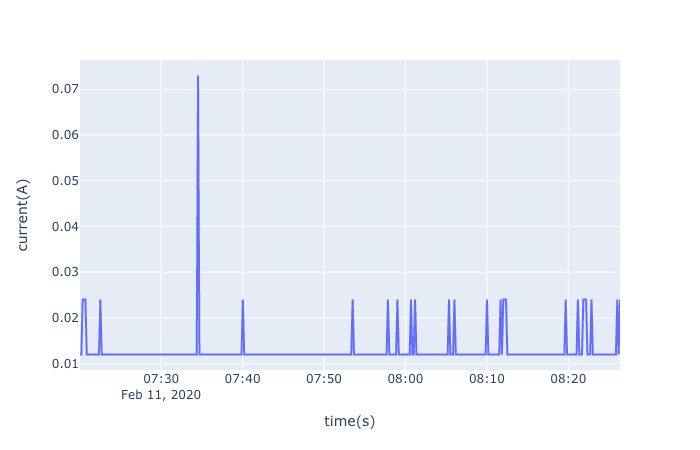

In [29]:
df = pd.read_csv("../../data/202002-current-tests/20200210-current-test-no-source-100k-prime-mac-powered.csv",parse_dates=["time(s)"], 
                 date_parser=lambda row: pd.to_datetime(row, unit='s'))
fig = px.line(df,x="time(s)", y="current(A)")
fig.show(renderer="png")

3. Plugged the Arduino into Raspberry Pi USB port but used the Arduino barrel connector to power it - the readings were immediately seen to fluctuate. See interactive plot [here](https://dev.lilley.io/kelvin/?dataset=20200213-current-test-no-source-100k-prime-arduino-DC-plug&deltat=-1)
4. Plugged the Arduino into Mac USB port (Mac plugged into mains) but used the Arduino barrel connector to power it using a cheap AC-DC convertor - the readings would also fluctuate. I could turn the fluctuations on and off at will by simply unplugging the barrel connected so that the Arduino would switch to the Mac power source. See interactive plot [here](https://dev.lilley.io/kelvin/?dataset=20200213-current-test-no-source-100k-prime-arduino-DC-plug-mac-connect&deltat=-1).
5. I got a battery pack and used it to power the Arduino in a couple of ways, a) plugged it into the Arduino 5V pin connector, b) plugged it into the Raspberry pi so that the Pi and hence the Arduino were powered from the battery pack. There were still a lot of fluctuations as you can see in the interactive plot [here](https://dev.lilley.io/kelvin/?dataset=20200217-current-test-no-source-100k-prime-arduino-battery&deltat=-1).
6. I used a DC power source that I forgot I had. I connected it to both the barrel connector of the Arduino and the 5V pins and both produced large fluctuations.
7. Plugged the Arduino USB into my Linux PC USB running plugged into the mains - it was not as stable as the Mac but the high frequency oscillations appeared to be taken care of as you can see below (also the interactive plot [here](https://dev.lilley.io/kelvin/?dataset=20200217-current-test-no-source-100k-prime-linux-powered&deltat=-1)).

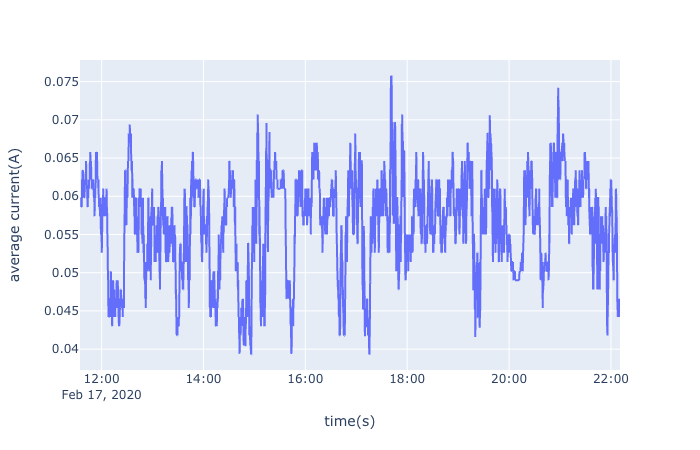

In [30]:
df = pd.read_csv("../../data/202002-current-tests/20200217-current-test-no-source-100k-prime-linux-powered.csv",parse_dates=["time(s)"], 
                 date_parser=lambda row: pd.to_datetime(row, unit='s'))
df["average current(A)"] = df.rolling(10,center=True).mean()
fig = px.line(df,x="time(s)", y="average current(A)")
fig.show(renderer="png")

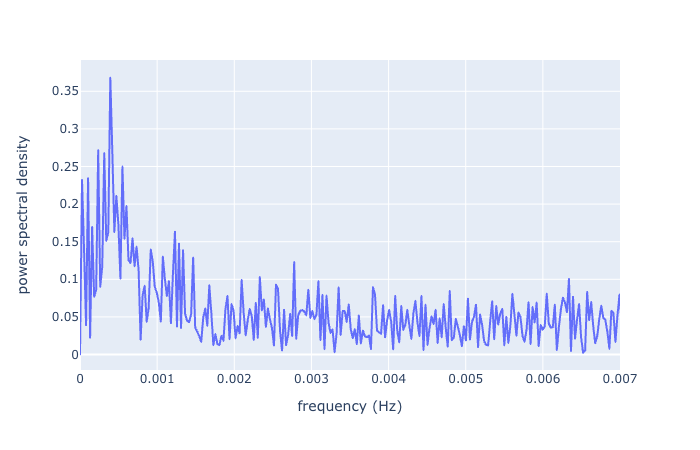

In [31]:
fig = plot_spec("../../data/202002-current-tests/20200217-current-test-no-source-100k-prime-linux-powered.csv")
fig.show(renderer="png")

The Arduino plugged into the Mac was by far the best solution, so I set it running for about 24 hours to measure zero current:

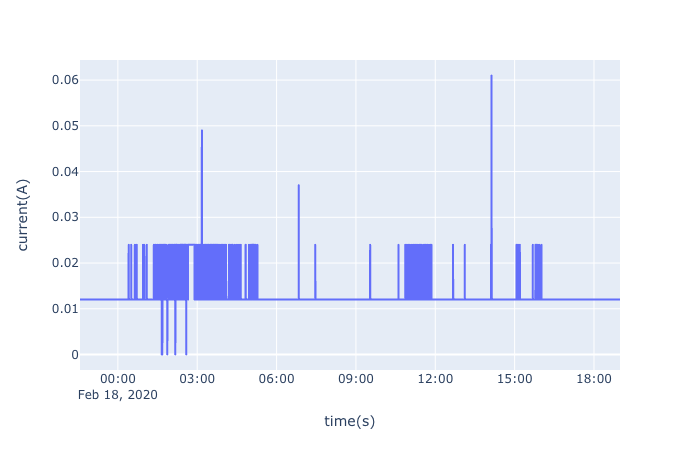

In [32]:
df = pd.read_csv("../../data/202002-current-tests/20200217-current-test-no-source-100k-prime-mac-powered.csv",parse_dates=["time(s)"], 
                 date_parser=lambda row: pd.to_datetime(row, unit='s'))
fig = px.line(df,x="time(s)", y="current(A)")
fig.show(renderer="png")

The fluctuations are minimal as you can see in histogram below - 93% of all the current measurments are coming from a single arduino bin.

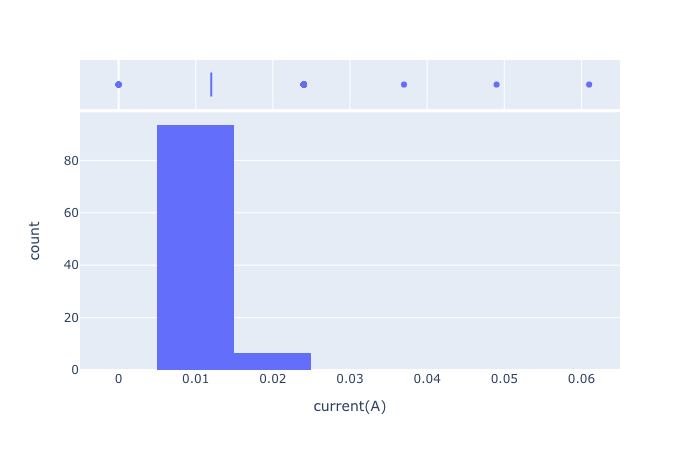

In [33]:
fig = px.histogram(df, x="current(A)",histnorm='percent',marginal="box")
fig.show(renderer="png")

We can also see in the power spectrum that there are are no significant high frequency components. There does appear to be a very low frequency component at 27$\mu$Hz but it is nowhere near as significant as we have seen in the other tests.

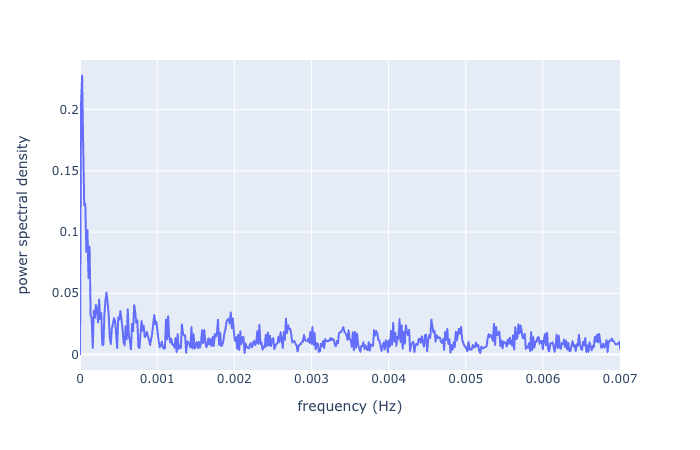

In [34]:
fig = plot_spec("../../data/202002-current-tests/20200217-current-test-no-source-100k-prime-mac-powered.csv")
fig.show(renderer="png")

Now that I've got a decent zero reading, it's time to measure the current from the heating jacket again (full interactive plot [here](https://dev.lilley.io/kelvin/?dataset=20200219-current-test-100k-prime-mac-powered&deltat=-1))

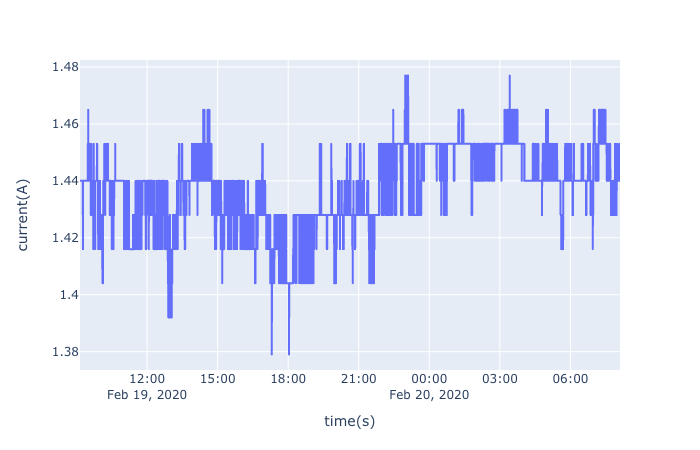

In [35]:
df = pd.read_csv("../../data/202002-current-tests/20200219-current-test-100k-prime-mac-powered.csv",parse_dates=["time(s)"], 
                 date_parser=lambda row: pd.to_datetime(row, unit='s'))
fig = px.line(df,x="time(s)",y="current(A)")
fig.show(renderer="png")

There is clearly still some kind of long timescale changes in current that we saw at the start of our analysis. Again looking at the moving average makes this more apparent - we'll look at a 10 min averaging window.

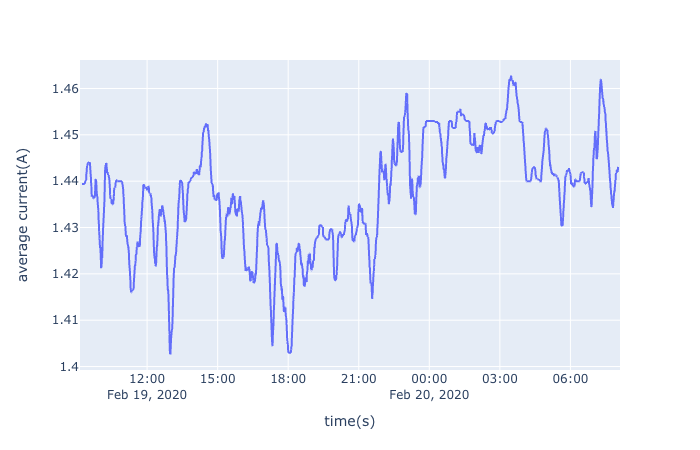

In [36]:
df["average current(A)"] = df.rolling(60,center=True).mean()
fig = px.line(df,x="time(s)", y="average current(A)")
fig.show(renderer="png")

The power spectrum tells us that there is a $12\mu$Hz frequency, i.e.a 23hr cycle.

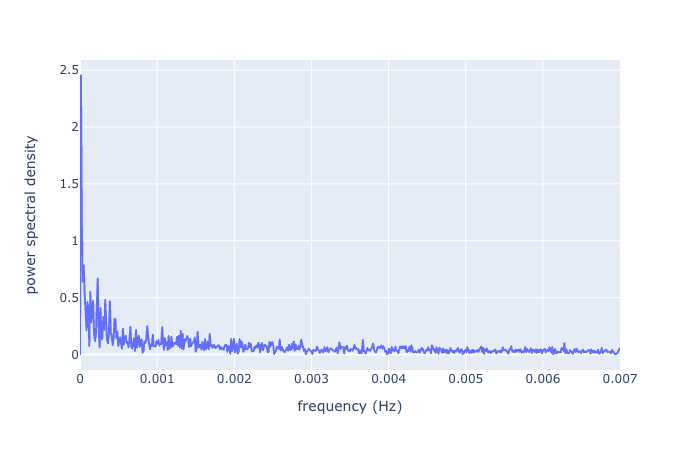

In [37]:
fig = plot_spec("../../data/202002-current-tests/20200219-current-test-100k-prime-mac-powered.csv")
fig.show(renderer="png")

Looking at the histogram, we see that 85% of the data is contained within 3 arduino sensor bins, 35% at the average of 1.44A and 50% at ±0.013A from this average i.e. ±0.9%

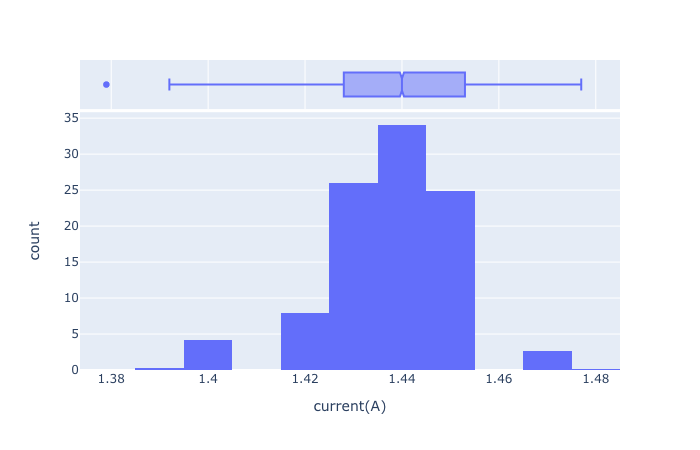

In [38]:
fig = px.histogram(df, x="current(A)",histnorm='percent',marginal="box")
fig.show(renderer="png")